In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import ttest_1samp
from scipy.special import gammaln
import scipy.stats as st
import numdifftools as nd

# Obtain data

In [2]:
symbols = ['^GSPC', 'GOOG', 'MSFT']
symbols = ['^AEX', '^BFX', '^GDAXI']
start_date = '2010-01-01'
start_date = '2000-01-01'
end_date = '2022-04-08'
vPrices = yf.download(symbols, start=start_date, end=end_date)['Close'].dropna()
vReturns = vPrices.pct_change().dropna() * 100
vReturns = np.log(vPrices / vPrices.shift(1)).dropna() *100
vNpReturns = np.array(vReturns.transpose())
vTrain = vNpReturns[:,:int(len(vNpReturns[0,:]) * 0.8)]
vTest = vNpReturns[:,int(len(vNpReturns[0,:]) * 0.8):]

[*********************100%***********************]  3 of 3 completed


In [3]:
np.corrcoef(vTrain)

array([[1.        , 0.85779633, 0.86491844],
       [0.85779633, 1.        , 0.78047809],
       [0.86491844, 0.78047809, 1.        ]])

# CCC Model

### Here We will focuss on the CCC model and its loglikelihood 

In [4]:
def fnGARCH1Model(vPar, vData):
    iT = len(vData)
    dOmega = vPar[0]
    dAlpha = vPar[1]
    dBeta = vPar[2]

    vSig2 = np.zeros(iT)
    vSig2[0] = np.var(vData)

    for t in range(1,iT):
        vSig2[t] = dOmega + dAlpha * vData[t-1]**2 + dBeta * vSig2[t-1]
    return vSig2

def fnMinusNormalLogLiklihood(vPar, vData):
    vSig2 = fnGARCH1Model(vPar, vData)
    ll = -(1/2) * np.log(2*np.pi) - (1/2) * np.log(vSig2) - (1/2) * vData**2 / vSig2
    ll = np.sum(ll)
    return -ll

def fnMinusStudentTLogLiklihood(vPar, vData):
    vH = fnGARCH1Model(vPar, vData)
    dNu = vPar[3]
    ll = gammaln( (dNu+1)/2 ) - gammaln( dNu/2 ) - 0.5*np.log( (dNu-2)*np.pi*vH ) - 0.5*(dNu+1)*np.log( 1 +  (vData**2)/((dNu-2)*vH) ) 
    ll = np.sum(ll)
    return -ll

def fnMinimiseCCCNormal(vData, vIni):
    results = minimize(fnMinusNormalLogLiklihood, vIni, args= vData, method= "SLSQP")
    results = [np.exp(results.x[0]), np.exp(results.x[1])/(1+np.exp(results.x[1])), np.exp(results.x[2])/(1+np.exp(results.x[2]))]
    return results

def fnMinimiseCCCStudentT(vData, vIni):
    results = minimize(fnMinusStudentTLogLiklihood, vIni, args= vData, method= "SLSQP")
    results = [np.exp(results.x[0]), np.exp(results.x[1])/(1+np.exp(results.x[1])), np.exp(results.x[2])/(1+np.exp(results.x[2]))]
    return results

def fnThreeDimMulti(m1, m2):
    m3 = np.zeros(m1.shape)
    for t in range(m1.shape[2]):
        m3[:,:,t] = m1[:,:,t] @ m2[:,:,t]
    return m3

In [5]:
# One step code

def fnCCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*3 + p]
                mR[j,i] = vPar[iN*3 + p]
                p += 1
    dLL = 0
    for t in range(iT):
        mSigt[:,:,t] = mDt[:,:,t] @ mR @ mDt[:,:,t]
        dLL += iN*np.log(2*np.pi) + np.log(np.linalg.det(mSigt[:,:,t])) + mData[:,t].transpose() @ np.linalg.inv(mSigt[:,:,t]) @ mData[:,t]
    dLL = -(1/2)*dLL
    print(dLL)
    return -dLL 


In [ ]:
import scipy 

In [ ]:
bounds = [(0.00000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999)]*3 + [(-1, 1)]*3


options = {'maxiter': 10000}
results = minimize(fnCCCOneStep, [np.var(vNpReturns[0,:])*(1-0.10-0.10), 0.10, 0.10, np.var(vNpReturns[1,:])*(1-0.10-0.10), 0.10, 0.10, np.var(vNpReturns[2,:])*(1-0.10-0.10), 0.10, 0.10, 0.63, 0.69, 0.75], bounds= bounds, options= options, args= vNpReturns, method= "Nelder-Mead")
results 

In [6]:
def StudentTCopula(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    vLL = np.zeros(iN)
    mI = np.identity(iN)
    mR = np.identity(mData.shape[0])
    mSig = np.zeros(mData.shape)
    mUt = np.zeros(mData.shape)
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        vLL[i] = -1 * fnMinusStudentTLogLiklihood(vPar[i*4 : (i+1)*4], mData[i, :])
        mSig[i,:] = fnGARCH1Model(vPar[i*4 : (i+1)*4], mData[i, :])
        ##print(vPar[i*4 : (i+1)*4])
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*4 + p]
                mR[j,i] = vPar[iN*4 + p]
                p += 1
        mUt[i, :] = st.t.cdf(mData[i,:], vPar[(i+1)*4-1], loc=np.zeros(mData.shape[1]), scale=np.sqrt((vPar[(i+1)*4-1]-2)/vPar[(i+1)*4-1]*mSig[i,:]))
        #print(vPar[(i+1)*4-1])
    mQuantile= st.t.ppf(mUt, vPar[-1], loc=np.zeros(mUt.shape), scale=np.ones(mUt.shape))
    dLL = 0 
    dNu = vPar[-1]
    n=3
    for t in range(iT):
        vX = mQuantile[:, t]
        # dLogLikelihood = gammaln((dNu+2)/2) + gammaln(dNu/2) - iN * gammaln((dNu+1)/2) - 1/2 * np.log(np.linalg.det(mR)) -(dNu+iN)/2 *np.log(1+(vX.T@np.linalg.inv(mR)@vX)/dNu) + (dNu+1)/2 * np.log(1+vX[0]**2/dNu) + (dNu+1)/2* np.log(1+vX[1]**2/dNu) + (dNu+1)/2* np.log(1+vX[2]**2/dNu)   
        dLogLikelihood = gammaln((dNu+n)/2)+(n-1)*gammaln(dNu/2)-n*gammaln((dNu+1)/2)-0.5*np.log(np.linalg.det(mR))-(dNu+n)/2*np.log(1+(vX.T@np.linalg.inv(mR)@vX)/(dNu))+ (dNu+1)/2 * np.log(1+vX[0]**2/dNu) + (dNu+1)/2* np.log(1+vX[1]**2/dNu) + (dNu+1)/2* np.log(1+vX[2]**2/dNu)   
        dLL += dLogLikelihood
    if vPar[1] + vPar[2] > 1:
        dLL = - np.inf
    elif vPar[5] + vPar[6] > 1:
        dLL = - np.inf
    elif vPar[9] + vPar[10] > 1:
        dLL = -np.inf
    print(dLL + np.sum(vLL)) 
    return -(dLL + np.sum(vLL)) 

In [12]:
def StudentTCopula_LL(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    vLL = np.zeros(iN)
    mI = np.identity(iN)
    mR = np.identity(mData.shape[0])
    mSig = np.zeros(mData.shape)
    mUt = np.zeros(mData.shape)
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        vLL[i] = -1 * fnMinusStudentTLogLiklihood(vPar[i*4 : (i+1)*4], mData[i, :])
        mSig[i,:] = fnGARCH1Model(vPar[i*4 : (i+1)*4], mData[i, :])
        ##print(vPar[i*4 : (i+1)*4])
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*4 + p]
                mR[j,i] = vPar[iN*4 + p]
                p += 1
        mUt[i, :] = st.t.cdf(mData[i,:], vPar[(i+1)*4-1], loc=np.zeros(mData.shape[1]), scale=np.sqrt((vPar[(i+1)*4-1]-2)/vPar[(i+1)*4-1]*mSig[i,:]))
        #print(vPar[(i+1)*4-1])
    mQuantile= st.t.ppf(mUt, vPar[-1], loc=np.zeros(mUt.shape), scale=np.ones(mUt.shape))
    dLL = 0 
    dNu = vPar[-1]
    n=3
    for t in range(iT):
        vX = mQuantile[:, t]
        dLogLikelihood = gammaln((dNu+n)/2)+(n-1)*gammaln(dNu/2)-n*gammaln((dNu+1)/2)-0.5*np.log(np.linalg.det(mR))-(dNu+n)/2*np.log(1+(vX.T@np.linalg.inv(mR)@vX)/(dNu))+ (dNu+1)/2 * np.log(1+vX[0]**2/dNu) + (dNu+1)/2* np.log(1+vX[1]**2/dNu) + (dNu+1)/2* np.log(1+vX[2]**2/dNu)   
        dLL += dLogLikelihood
    return -(dLL + np.sum(vLL)) 

In [16]:
ini = [np.var(vNpReturns[0,:])*(1-0.10-0.10), 0.10, 0.10, 4, np.var(vNpReturns[1,:])*(1-0.10-0.10), 0.20, 0.20, 4, np.var(vNpReturns[2,:])*(1-0.10-0.10), 0.30, 0.30, 4, 0.63, 0.69, 0.75, 4]

In [32]:
StudentTCopula(ini, vNpReturns)

[-0.33354832  0.04262917 -0.33408621]
-17593.75835336141


17593.75835336141

In [26]:
ini = [0.01585982, 0.05535915, 0.93862185, 5.72929661, 0.02007743,
       0.06195244, 0.92807856, 5.19403169, 0.01728228, 0.05447404,
       0.94178285, 5.68659249, 0.8222625 , 0.86292527, 0.77999021,
       2.53629195]

# ini = [0.01477538, 0.05216626, 0.93574953, 9.05506017, 0.01896502,
#        0.05923609, 0.92279149, 7.6293927 , 0.01611129, 0.05031933,
#        0.93984678, 8.45812647, 0.83961461, 0.87900556, 0.80127861,
#        4.8366569 ]

In [34]:
bounds = [(0.00001, 50), (0.00000001, 0.99999999), (0.00000001, 0.99999999), (2.1, 200)]*3 + [(-1, 1)]*3 + [(2.1, 200)]
# ini = [np.var(vNpReturns[0,:])*(1-0.10-0.10), 0.10, 0.10, 4, np.var(vNpReturns[1,:])*(1-0.10-0.10), 0.20, 0.20, 4, np.var(vNpReturns[2,:])*(1-0.10-0.10), 0.30, 0.30, 4, 0.85, 0.85, 0.75, 4]
ini1 = [0.01665339, 0.09992014, 0.8920186, 3, 0.02265366, 0.1183659,  0.86801408, 3, 0.02047692, 0.08626776, 0.90451003,3, 0.85, 0.85, 0.75, 3]
#options = {'ftol': 1e-1000}
options = {'maxiter': 20000, 'maxfev': 20000, 'adaptive': True}
results = minimize(StudentTCopula, ini, args= vTrain, method= "Nelder-Mead", options= options, bounds = bounds)
results

-14394.09915250137
-14394.602714841354
-14399.201935769779
-inf
-14394.940061683727
-14394.653096325115
-14397.395762423163
-inf
-14394.89301250711
-14394.49562968748
-14398.69498430605
-inf
-14394.138812418438
-14497.214077179135
-14590.761359075499
-14452.959747430674
-14393.99713373598
-16050.13371845934
-15235.28829524829
-15525.559180707893
-inf
-15330.041252910632
-inf
-15024.677955826923
-inf
-14911.535019145624
-inf
-14854.384629476957
-inf
-14737.23170775244
-inf
-14675.592351619356
-inf
-14642.212753429689
-inf
-14577.772901857323
-inf
-14545.643892998603
-inf
-14526.463217242577
-14480.108670045556
-inf
-14488.88294716278
-inf
-14473.38298450305
-14577.283057980756
-14464.273725723935
-14458.652831403333
-14550.164905772104
-14441.448652770197
-14569.630142590444
-14441.71751817036
-14493.762499716817
-14435.80670880231
-14485.881419753738
-14430.552639299896
-14491.066856653777
-14430.415152185149
-14427.367337142241
-14478.17325970924
-14419.410092506881
-14468.80036221115

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14392.940662758387
             x: [ 1.480e-02  5.272e-02 ...  8.033e-01  4.870e+00]
           nit: 1560
          nfev: 2207
 final_simplex: (array([[ 1.480e-02,  5.272e-02, ...,  8.033e-01,
                         4.870e+00],
                       [ 1.480e-02,  5.272e-02, ...,  8.033e-01,
                         4.870e+00],
                       ...,
                       [ 1.480e-02,  5.272e-02, ...,  8.033e-01,
                         4.870e+00],
                       [ 1.480e-02,  5.272e-02, ...,  8.033e-01,
                         4.870e+00]]), array([ 1.439e+04,  1.439e+04, ...,  1.439e+04,  1.439e+04]))

In [35]:
results.x

array([0.01480373, 0.0527172 , 0.93613114, 8.14025503, 0.01888444,
       0.05928659, 0.92392937, 7.00785245, 0.01611683, 0.05076903,
       0.94003131, 8.11499009, 0.84118762, 0.87977984, 0.80325331,
       4.87038598])

In [39]:
mHessian = nd.Hessian(StudentTCopula_LL, step= 1e-5)(results.x, mData = vTrain)
mCov1 = np.linalg.inv( mHessian )
np.sqrt(mCov1.diagonal()) 

array([0.00218901, 0.00435335, 0.00500153, 0.69139953, 0.00283103,
       0.00576667, 0.00702792, 0.52107692, 0.00261798, 0.00426984,
       0.00480454, 0.72466543, 0.00509261, 0.00393458, 0.00614144,
       0.31535865])

In [6]:
vStudentTCopula = [0.01480373, 0.0527172 , 0.93613114, 8.14025503, 0.01888444,
       0.05928659, 0.92392937, 7.00785245, 0.01611683, 0.05076903,
       0.94003131, 8.11499009, 0.84118762, 0.87977984, 0.80325331,
       4.87038598]

In [17]:
vStudentTCopulaSE = [0.00218901, 0.00435335, 0.00500153, 0.69139953, 0.00283103,
       0.00576667, 0.00702792, 0.52107692, 0.00261798, 0.00426984,
       0.00480454, 0.72466543, 0.00509261, 0.00393458, 0.00614144,
       0.31535865]

In [42]:
np.array(vStudentTCopula).round(4)

array([0.0148, 0.0527, 0.9361, 8.1403, 0.0189, 0.0593, 0.9239, 7.0079,
       0.0161, 0.0508, 0.94  , 8.115 , 0.8412, 0.8798, 0.8033, 4.8704])

In [43]:
np.array(vStudentTCopulaSE).round(4)

array([0.0022, 0.0044, 0.005 , 0.6914, 0.0028, 0.0058, 0.007 , 0.5211,
       0.0026, 0.0043, 0.0048, 0.7247, 0.0051, 0.0039, 0.0061, 0.3154])

##### Now we we calculate the diagonal matrix of the ccc model called the $D_t$ FOR THE NORMAL DISTRIBUTION

In [ ]:
iN = np.shape(vNpReturns)[0]
iT = np.shape(vNpReturns)[1]

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vNpReturns, axis=1)
for d in range(iN):
    for t in range(1,iT):
        mDtElements[d,t] = results.x[d*3] + results.x[d*3 + 1] * np.array(vNpReturns[d,t-1])**2 + results.x[d*3 +2] * mDtElements[d,t-1]
        
mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)
p=0
mR = np.identity(vNpReturns.shape[0])
for i in range(iN):
    for j in range(iN):
        if i < vNpReturns.shape[0] & j > i:
            mR[i,j] = results.x[iN*3 + p]
            mR[j,i] = results.x[iN*3 + p]
            p += 1
mCorMultiDim = np.tile(mR[:, :, np.newaxis], (1, 1, vNpReturns.shape[1]))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)

In [ ]:
#n is the number of stocks
iN = np.shape(vNpReturns)[0]
iT = np.shape(vNpReturns)[1]
mEstimates = np.zeros((iN,3))         #standard for any case since we have 3 parameters omega, alpha and beta
for i in range(iN):
    mEstimates[i,:] = fnMinimiseCCCNormal(vNpReturns[i,:], [np.var(vNpReturns[i,:])*(1-0.2-0.2) ,0.2, 0.2])
#mEstimates = np.from_numpy(mEstimates)

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vNpReturns, axis=1)

for t in range(1,iT):
    mDtElements[:,t] = mEstimates[:,0] + mEstimates[:,1] * np.array(vNpReturns[:,t-1])**2 + mEstimates[:,2] * mDtElements[:,t-1]

mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)

mE = vNpReturns / np.sqrt(mDtElements)
mCor = np.corrcoef(mE)
mCorMultiDim = np.tile(mCor[:, :, np.newaxis], (1, 1, iT))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)


In [ ]:
plt.plot(vNpReturns[0,:]**2)
plt.plot(mSigmat[0,0,:] - vNpReturns.mean())


In [ ]:
plt.plot(vNpReturns[0,:]**2)
plt.plot(mSigmat[0,0,:])


# AIC BIC Stuff

In [14]:
def fnAIC(k, dLL):
    return 2*k -2*dLL

def fnBIC(k, dLL, vData = vTrain):
    return k*np.log(len(vData[0,:])) -2*dLL

In [21]:
vIC_CCC_Copula=['CCC-Copula-ST',len(vStudentTCopula), StudentTCopula_LL(vStudentTCopula, vTrain)*-1, fnAIC(len(vStudentTCopula), StudentTCopula_LL(vStudentTCopula, vTrain)*-1), fnBIC(len(vStudentTCopula), StudentTCopula_LL(vStudentTCopula, vTrain)*-1)]

In [22]:
df_IC = pd.DataFrame(columns=['Model','Number Of Parameters', 'Log Likelihood', 'AIC', 'BIC'], data=[vIC_CCC_Copula])

In [23]:
print(df_IC.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
        Model &  Number Of Parameters &  Log Likelihood &          AIC &          BIC \\
\midrule
CCC-Copula-ST &                    16 &   -14392.940663 & 28817.881326 & 28920.509712 \\
\bottomrule
\end{tabular}



C:\Users\onim-\AppData\Local\Temp\ipykernel_20740\2965693198.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_IC.to_latex(index=False))


In [26]:
def StudentTCopula_Prediction(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    vLL = np.zeros(iN)
    mI = np.identity(iN)
    mR = np.identity(mData.shape[0])
    mSig = np.zeros(mData.shape)
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mUt = np.zeros(mData.shape)
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        vLL[i] = -1 * fnMinusStudentTLogLiklihood(vPar[i*4 : (i+1)*4], mData[i, :])
        mSig[i,:] = fnGARCH1Model(vPar[i*4 : (i+1)*4], mData[i, :])
        mDt[i, i, :] = np.sqrt(mSig[i,:])
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*4 + p]
                mR[j,i] = vPar[iN*4 + p]
                p += 1
        mUt[i, :] = st.t.cdf(mData[i,:], vPar[(i+1)*4-1], loc=np.zeros(mData.shape[1]), scale=np.sqrt((vPar[(i+1)*4-1]-2)/vPar[(i+1)*4-1]*mSig[i,:]))
        #print(vPar[(i+1)*4-1])

    dLL = 0 
    dNu = vPar[-1]
    n=3
    for t in range(iT):
        mSigt[:,:,t] = mDt[:,:,t] @ mR @ mDt[:,:,t]
    return mSigt

In [29]:
mPred_Copula_ST = StudentTCopula_Prediction(vStudentTCopula, vTest)

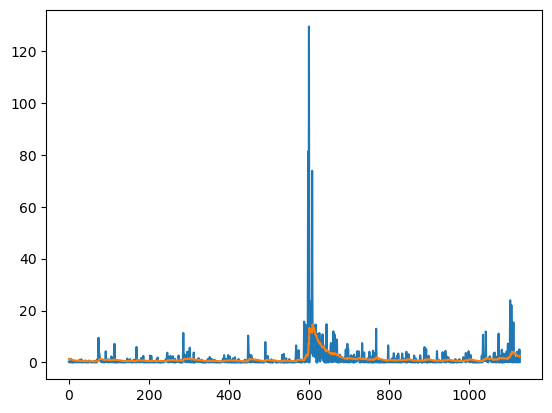

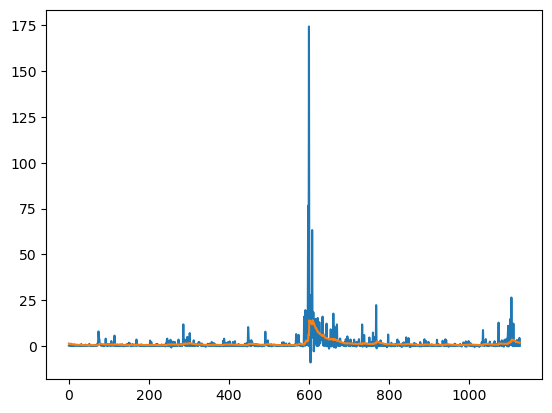

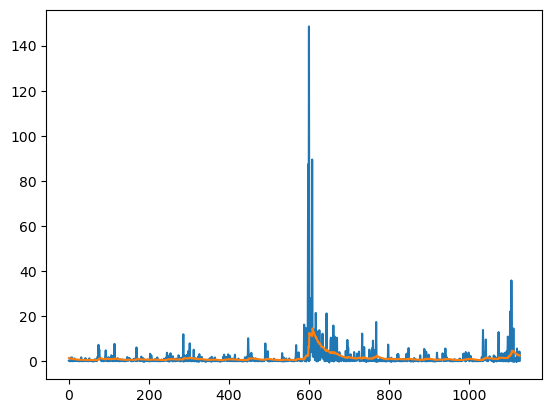

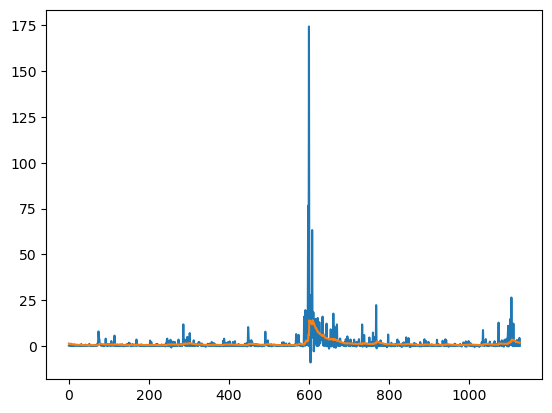

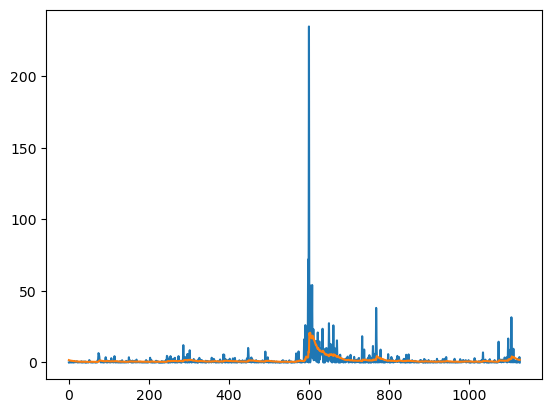

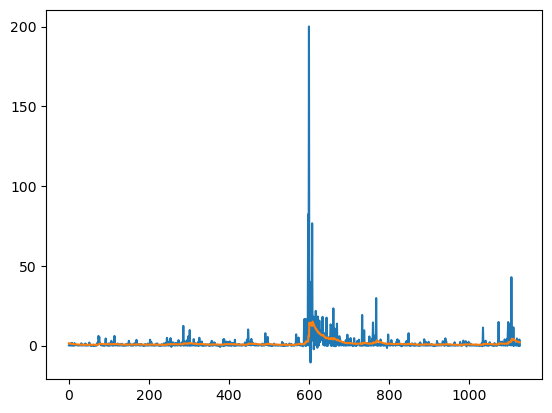

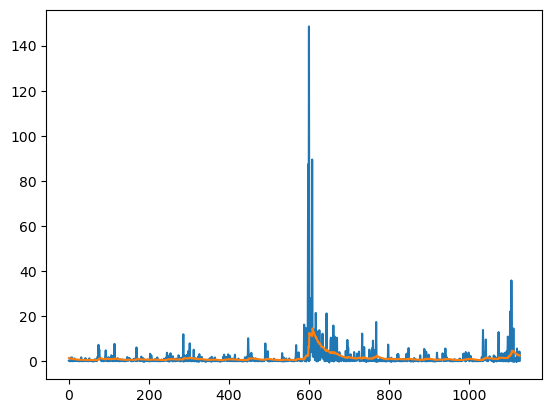

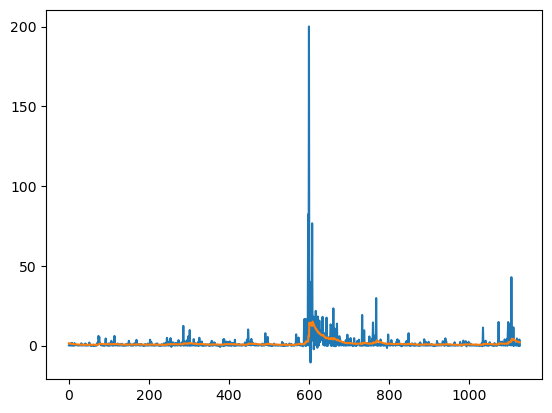

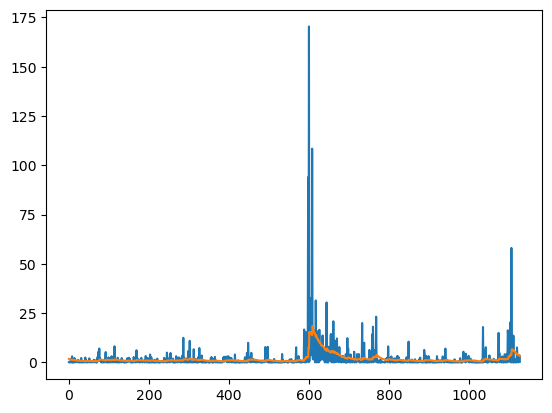

In [30]:
for i in range(3):
    for j in range(3):
        plt.plot(vTest[i, :] * vTest[j, :], label="vTest[{}]*vTest[{}]".format(i, j))
        plt.plot(mPred_Copula_ST[i, j], label="mPred_Copula[{}, {}]".format(i, j))
        plt.show()

In [31]:
np.save('mPred_Copula_ST.npy', mPred_Copula_ST)

In [7]:
def fnMinusStudentTLogLiklihoodLSR(vPar, vData):
    vH = fnGARCH1Model(vPar, vData)
    dNu = vPar[3]
    ll = gammaln( (dNu+1)/2 ) - gammaln( dNu/2 ) - 0.5*np.log( (dNu-2)*np.pi*vH ) - 0.5*(dNu+1)*np.log( 1 +  (vData**2)/((dNu-2)*vH) ) 
    return ll

In [9]:
def StudentTCopula_LSR(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    vLL = np.zeros((iN, iT))
    mI = np.identity(iN)
    mR = np.identity(mData.shape[0])
    mSig = np.zeros(mData.shape)
    mUt = np.zeros(mData.shape)
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        vLL[i] =  fnMinusStudentTLogLiklihoodLSR(vPar[i*4 : (i+1)*4], mData[i, :])
        mSig[i,:] = fnGARCH1Model(vPar[i*4 : (i+1)*4], mData[i, :])
        ##print(vPar[i*4 : (i+1)*4])
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*4 + p]
                mR[j,i] = vPar[iN*4 + p]
                p += 1
        mUt[i, :] = st.t.cdf(mData[i,:], vPar[(i+1)*4-1], loc=np.zeros(mData.shape[1]), scale=np.sqrt((vPar[(i+1)*4-1]-2)/vPar[(i+1)*4-1]*mSig[i,:]))
        #print(vPar[(i+1)*4-1])
    mQuantile= st.t.ppf(mUt, vPar[-1], loc=np.zeros(mUt.shape), scale=np.ones(mUt.shape))
    dLL = np.zeros(iT) 
    dNu = vPar[-1]
    n=3
    for t in range(iT):
        vX = mQuantile[:, t]
        # dLogLikelihood = gammaln((dNu+2)/2) + gammaln(dNu/2) - iN * gammaln((dNu+1)/2) - 1/2 * np.log(np.linalg.det(mR)) -(dNu+iN)/2 *np.log(1+(vX.T@np.linalg.inv(mR)@vX)/dNu) + (dNu+1)/2 * np.log(1+vX[0]**2/dNu) + (dNu+1)/2* np.log(1+vX[1]**2/dNu) + (dNu+1)/2* np.log(1+vX[2]**2/dNu)   
        dLogLikelihood = gammaln((dNu+n)/2)+(n-1)*gammaln(dNu/2)-n*gammaln((dNu+1)/2)-0.5*np.log(np.linalg.det(mR))-(dNu+n)/2*np.log(1+(vX.T@np.linalg.inv(mR)@vX)/(dNu))+ (dNu+1)/2 * np.log(1+vX[0]**2/dNu) + (dNu+1)/2* np.log(1+vX[1]**2/dNu) + (dNu+1)/2* np.log(1+vX[2]**2/dNu)   
        dLL[t] = dLogLikelihood

    return dLL + np.sum(vLL, axis=0)

In [14]:
vLSR_Copula_st = StudentTCopula_LSR(vStudentTCopula, vTest)

In [15]:
np.sum(vLSR_Copula_st)

-3206.590808297408

In [16]:
np.save('vLSR_Copula_st.npy', vLSR_Copula_st)